# Pneumonia Opacity Segmentation


This is the code for the deep learning project. 

During this notebook a Unet is going to be build and used to predict segment x-ray images.





### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder  
import pydicom as dicom

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Data Load

Data is composed by the X-ray image, a label including the id and the position of the anomalies (if there is one) and finally a class {Pneumonia, Normal, Not pneumonia and Not normal}.

Loading the csv files. (images are loaded during train, dataset is too much large to be in memory).

Dividing on a Test set and Train Set. 20% and 80% respectively. 

In [2]:
DATA_PATH="./rsna-pneumonia-detection-challenge"

labels_frame = pd.read_csv(DATA_PATH + '/stage_2_train_labels.csv')

detailed_class_info = pd.read_csv(DATA_PATH + '/stage_2_detailed_class_info.csv')

total_images_size = len(detailed_class_info)

train_images_size = int(.8*total_images_size)

train_classes = detailed_class_info.iloc[:train_images_size,:]

train_data = labels_frame.iloc[:train_images_size,:]
train_data['class'] = train_classes['class'].values  

test_classes = detailed_class_info.iloc[train_images_size:,:]

test_data = labels_frame.iloc[train_images_size:,:]
test_data['class'] = test_classes['class'].values  


print(train_data.iloc[4,:])
print(train_data.iloc[5,:])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
class                                Lung Opacity
Name: 4, dtype: object
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             562
y                                             152
width                                         256
height                                        453
Target                                          1
class                                Lung Opacity
Name: 5, dtype: object



#### Function to display the image and overlap with the mask

In [70]:
def show_square(image,msk,classes):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
        # threshold true mask
    comp = msk[:,:] > 0.7
        # apply connected components
    comp = measure.label(comp)
        # apply bounding boxes
    for region in measure.regionprops(comp):
    
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            ax.add_patch(plt.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
    
    plt.show()

#### Function to display the image and overlap with the mask and the prediction 

In [256]:
def show_square_predicted(image,msk,predicted):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
        # threshold true mask
    comp = msk[:,:] > 0.7
        # apply connected components
    comp = measure.label(comp)
        # apply bounding boxes
    for region in measure.regionprops(comp):
    
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            ax.add_patch(plt.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
    
    comp = predicted[:,:] > 0.7
        # apply connected components
    comp = measure.label(comp)
        # apply bounding boxes
    for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            ax.add_patch(plt.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
    
    

#### Data Loader 
The data loader is responsible for creating the mask and also return an image given an index. It also shuffles the dataset. 

In [297]:
class PneumoniaDataset(data.Dataset):

    def __init__(self, data, root_dir,image_size=128):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_size = image_size
        self.landmarks_frame = data
        self.idx = data["patientId"].drop_duplicates()
        self.root_dir = root_dir

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,
                                self.idx.iloc[idx] + ".dcm")
        image = dicom.read_file(img_name).pixel_array
        msk = np.zeros(image.shape)
        landmarks = self.landmarks_frame.loc[(self.landmarks_frame['patientId'] == self.idx.iloc[idx])].iloc[:,1:].as_matrix()
        landmarks = landmarks.reshape(-1, 6)
        for location in landmarks:
                if pd.notna(location[0]):
                    x, y, w, h = location[0:4].astype(int)
                    msk[y:y+h, x:x+w] = 1
        image = resize(image, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        sample = {'image': image,'msk':msk, 'classes': landmarks}
        

        return sample
    def shuffle_data(self):
        self.idx = self.idx.sample(frac=1).reset_index(drop=True)


### Exploring Data 

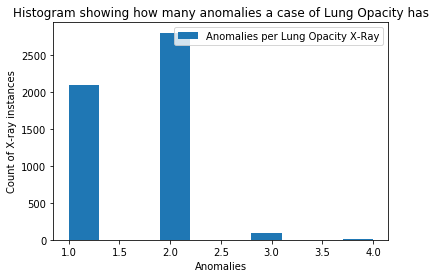

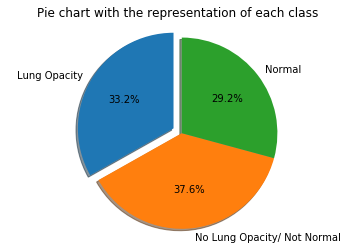

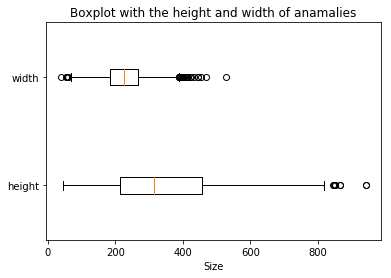

In [298]:
x = train_data.loc[train_data['class'] == 'Lung Opacity'][['patientId','class']].groupby(['patientId','class']).size()


plt.hist(x,label='Anomalies per Lung Opacity X-Ray')
plt.legend()
plt.title('Histogram showing how many anomalies a case of Lung Opacity has')
plt.ylabel('Count of X-ray instances')
plt.xlabel('Anomalies')

plt.show()

x = train_data[['patientId','class']].groupby('class').size()

plt.pie(x,labels= ["Lung Opacity","No Lung Opacity/ Not Normal","Normal"],autopct='%1.1f%%',explode=( 0.1, 0, 0),shadow=True, startangle=90 )
plt.title('Pie chart with the representation of each class')
plt.axis('equal')
plt.show()



plt.boxplot([train_data.loc[train_data['class'] == 'Lung Opacity'].height,train_data.loc[train_data['class'] == 'Lung Opacity'].width],vert=False,labels=["height","width"])
plt.title('Boxplot with the height and width of anamalies')
plt.xlabel('Size')
plt.show()


#### How does the image looks like when overlaped ?

00704310-78a8-4b38-8475-49f4573b2dbb
Sample #0 (128, 128) [[264.0 152.0 213.0 379.0 1 'Lung Opacity']
 [562.0 152.0 256.0 453.0 1 'Lung Opacity']]


<Figure size 432x288 with 0 Axes>

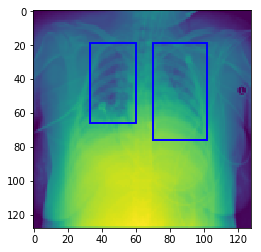

Sample #1 (128, 128) [[nan nan nan nan 0 'No Lung Opacity / Not Normal']]


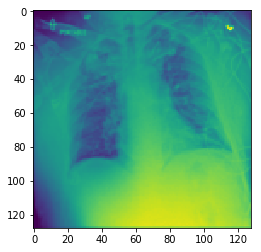

Sample #2 (128, 128) [[nan nan nan nan 0 'No Lung Opacity / Not Normal']]


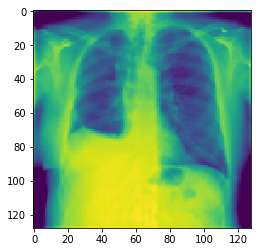

Sample #3 (128, 128) [[323.0 577.0 160.0 104.0 1 'Lung Opacity']
 [695.0 575.0 162.0 137.0 1 'Lung Opacity']]


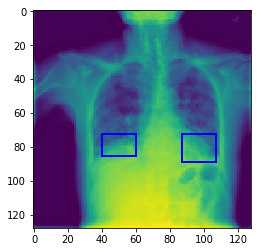

In [299]:
img_name = labels_frame.iloc[8, 0]
print(img_name)
labels = labels_frame.iloc[8, 1:5].as_matrix()
labels = labels.astype('float').reshape(-1, 2).T

pneumonia_dataset = PneumoniaDataset(data=train_data,
                                    root_dir='./rsna-pneumonia-detection-challenge/stage_2_train_images')

fig = plt.figure()
for i in range(len(pneumonia_dataset)):
    sample = pneumonia_dataset[i+4]
    print('Sample #{}'.format(i), sample['image'].shape, sample['classes'])
    show_square(**sample)
    if i == 3:
        break


### Utils

Convert numpy matrix to tensor. 

In [300]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, msk, landmarks = sample['image'], sample['msk'],sample['classes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape((1,1, len(image), -1))
       
        return {'image':  torch.tensor(torch.from_numpy(image)).type('torch.FloatTensor'),'msk': torch.tensor(torch.from_numpy(msk.astype(int))).type('torch.FloatTensor'),
                'classes': landmarks}

In [301]:
pneumonia_testset = PneumoniaDataset(data=test_data,
                                    root_dir='./rsna-pneumonia-detection-challenge/stage_2_train_images')

### Model

#### DownSampler
Separate input, out channels and decreases the resolution by a factor of 2.

In [302]:
class DownSampler(nn.Module):
    def __init__(self,in_channels,out_channels,input_size):
        super(DownSampler, self).__init__()
        self.batchnorm = nn.InstanceNorm2d(in_channels,momentum=0.9)
        self.activation = nn.LeakyReLU()
        self.conv1 = nn.Conv2d(in_channels,out_channels, kernel_size=1, padding=0, bias=False)
        self.max_pool = nn.MaxPool2d(2,stride=2)
        
    def forward(self,x):
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.max_pool(x)
        return x

#### ResbBlock

Performs two convolutions, followed by a skip connection 

In [303]:
class Resblock(nn.Module):
    def __init__(self,channels,input_size):
        super(Resblock, self).__init__()
        self.batchnorm1 = nn.InstanceNorm2d(channels,momentum=0.9)
        self.activation1 = nn.LeakyReLU()
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,padding=1,bias=False)
        self.batchnorm2 = nn.InstanceNorm2d(channels,momentum=0.5)
        self.activation2 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,padding=1,bias=False)
    
    def forward(self,inputs):
        x = self.batchnorm1(inputs)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.batchnorm2(x)
        x = self.activation2(x)
        x = self.conv2(x)
        return x + inputs

#### Overall model 

Aggregates the docksampler and resblocks and also has the responsability to upsample the output.

In [304]:
class Network(nn.Module):
    def __init__(self,input_size = 256):
        super(Network, self).__init__()
        original_size = input_size
        channels = 32
        self.conv1 = nn.Conv2d(1,channels,kernel_size=3, padding=1,bias=False)
        
        self.downsampler1 = DownSampler(channels,2*channels,input_size)
        channels = channels * 2
        input_size = input_size/2
        self.resblock1 = Resblock(channels,input_size)
        self.resblock2 = Resblock(channels,input_size)
        
        self.downsampler2 = DownSampler(channels,2*channels,input_size)
        channels = channels * 2
        input_size = input_size/2
        self.resblock3 = Resblock(channels,input_size)
        self.resblock4 = Resblock(channels,input_size)
        
        self.downsampler3 = DownSampler(channels,2*channels,input_size)
        channels = channels * 2
        input_size = input_size/2
        self.resblock5 = Resblock(channels,input_size)
        self.resblock6 = Resblock(channels,input_size)
        
        #self.downsampler4 = DownSampler(channels,2*channels,input_size)
        #channels = channels * 2
        #input_size = input_size/2
        #self.resblock7 = Resblock(channels,input_size)
        #self.resblock8 = Resblock(channels,input_size)
        
        self.batchnorm1 = nn.InstanceNorm2d(channels,momentum=0.9)
        self.activation1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(channels,1,1)
     
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2)
        
    
    def forward(self,inputs):
        x = self.conv1(inputs)
        
        x = self.downsampler1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        
        x = self.downsampler2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        
        x = self.downsampler3(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        
        #x = self.downsampler4(x)
        #x = self.resblock7(x)
        #x = self.resblock8(x)
        
        x = self.batchnorm1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.upsample1(x)
        
        x = self.upsample2(x)
        x = self.upsample3(x)
       
        return x
        
    def save_weights(self, weights_name ):
        weights_fname = weights_name
        weights_fpath = os.path.join("./", weights_fname)
        torch.save({'state_dict': self.state_dict()}, weights_fpath)
        

### Loss Function

Using Dice Coefficient Loss Function and Binary Cross Entropy. 

Combines both.

In [305]:
pos_weight = torch.ones([pneumonia_dataset.image_size])
criterion = nn.BCEWithLogitsLoss()
def dice(outputs, target):
    smooth=.001
    
    outputs=nn.functional.sigmoid( outputs.view(-1))
    target=target.view(-1)
    
    return(1-2*(outputs*target).sum()/(outputs.sum()+target.sum()+smooth))

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    
    return 0.5 * criterion(y_pred.view(-1),y_true.view(-1)) + 0.5 * dice(y_pred,y_true)




### Model Evaluation

Detects the number of False negatives, and True positives.

False negatives and True positives are based on a 0.5 threshold on the Dice Coefficient Loss

In [312]:
def evaluate_model(net, testloader):
    net.eval()
    tp = 0
    total = 0
    fn = 0
    with torch.no_grad():
        i = 0
        testloader.shuffle_data()
        while(i < len(testloader)):
        # Transfer to GPU
            sample = testloader[i]
            sample = transformer(sample)
            inputs = sample["image"]
            labels = sample["msk"]
            classes = sample["classes"]
            inputs, labels = inputs.to("cpu"), labels.to("cpu")
            outputs = net(inputs)
            iou_score = dice(outputs,labels.reshape(outputs.shape))
            if iou_score < 0.5 :
                tp += 1
            elif classes[0,4] != 0:
                fn +=1   
            i = i+1
            total = total+1
    return tp,total,fn

### Training

Initilize the Transformer, the optimizer and the scheduler.

In [309]:
net = Network(128)
transformer = ToTensor()
net.to("cpu")

optimizer = optim.Adam(net.parameters(), lr=1e-3)

n_epochs = 3
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

Performs training. At each epoch the model weights are saved.

In [ ]:
net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 150  # mini-batches
    i = 0
    scheduler.step()
    pneumonia_dataset.shuffle_data()
    while(i < len(pneumonia_dataset)):
        # Transfer to GPU
        sample = pneumonia_dataset[i]
        sample = transformer(sample)
        inputs = sample["image"]
        labels = sample["msk"]
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = iou_bce_loss(labels.reshape(outputs.shape),outputs)
        loss.backward()
        optimizer.step()
        i = i+1
        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.7f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0

    
    # Print accuracy after every epoch
    print ('Epoch %.d' % epoch)
    tp,tn,fn = evaluate_model(net, pneumonia_testset)
    #print('Mean  combined BCE and IoU Loss of the network on the test images: %.3f' % accuracy)
    
    print('TP: %.3f' % tp)
    
    print('FN: %.3f' % fn)
    print('Total: %.3f' % tn)
    net.save_weights("weights")
print('Finished Training')

### Performance Results

Predicts some images on the test set extracted from the training set at the beginning.

In [ ]:
show_square_predicted

fig = plt.figure()
for i in range(len(pneumonia_testset)):
    with torch.no_grad():
        sample = pneumonia_testset[i]
        print('Sample #{}'.format(i), sample['image'].shape, sample['classes'])
        sample = transformer(sample)
        inputs = sample["image"]
        labels = sample["msk"]
        classes = sample["classes"]
        predicted = net(inputs)
        
        #print(iou_bce_loss(sample['msk'].reshape(predicted.shape),predicted))
        show_square_predicted(sample['image'].reshape(-1,pneumonia_testset.image_size).numpy(),sample['msk'].reshape(-1,pneumonia_testset.image_size).numpy(),predicted.reshape(-1,pneumonia_testset.image_size).numpy())
        title = "./pred"+str(i)
        plt.show()
        #plt.savefig(title)
        if i == 20:
            break


### Save Model

In [268]:
filename = 'unetres.pth'
try:
    torch.save(net.state_dict(), filename)
    print('Model saved to %s' % filename)
except:
    raise Exception('The notebook should be run or validated with skip_training=True.')


Model saved to unetres.pth
